In [5]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
#from scipy.fft import fftshift
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries

In [3]:
m = const.M_sun
radi = const.kpc

In [9]:
def ReadExtrapolatedMode(file, mode = (2,2), order = 2, mass = 68 * const.M_sun, radius = 10000 * const.kpc):
    """ Read in an extrapolated SXS-format gravitational waveform mode """

    l = mode[0]
    m = mode[1]
    f = h5py.File(file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    time = time - time[0]
    
    ## Combine the real and imaginary parts of the data
    re_adj = re*const.G*mass/((const.c)**2*radius)
    im_adj = im*const.G*mass/((const.c)**2*radius)
    time_adj = time*mass*const.G/(const.c**3)
    
    #dt = 1/len(time_adj)
    # 
    dt = 1/4096
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_r = CubicSpline(time_adj,re_adj)
    cs_i = CubicSpline(time_adj,im_adj)
    
    real = cs_r(times)
    imag = cs_i(times)
    
    return times, real, imag, dt

In [12]:
# Please uncomment the line below and fill in the correct path
rh_file = "Waveforms/Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"

# Open the HDF5 file in read-only mode:
rh_data = h5py.File(rh_file,'r')

In [13]:
t, re, img, dt = ReadExtrapolatedMode(rh_file, mode = (2,2), order = 2)
print(dt)
print(int(1/dt))

0.000244140625
4096


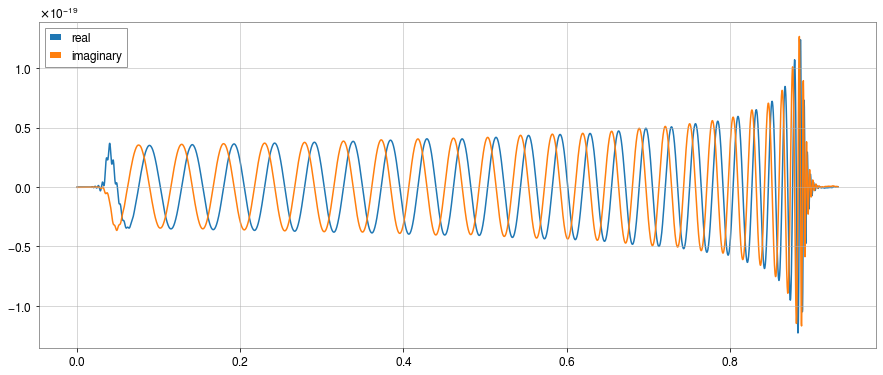

In [14]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, re, label = "real")
plt.plot(t, img, label = "imaginary")
plt.legend()
#plt.xlim(0, .35)
#plt.ylim(-1e-21, 1e-21)
plt.show()


In [15]:
h_plus = re + img
h_cross = re - img

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

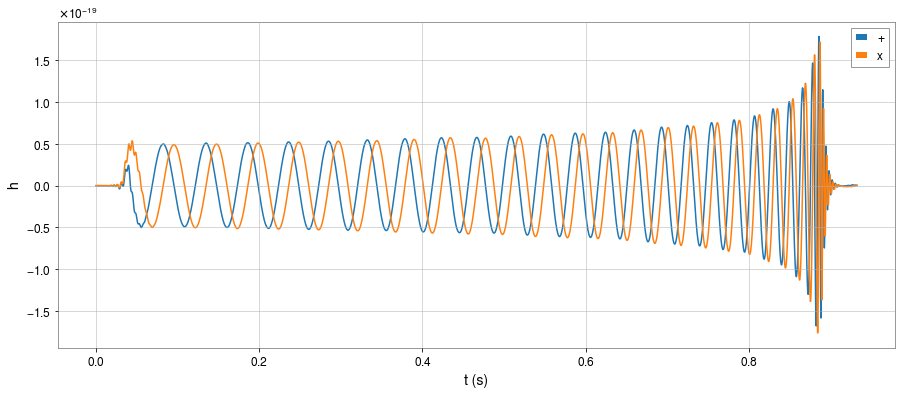

In [16]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, h_plus, label = '+')
plt.plot(t, h_cross, label = 'x')
plt.xlabel('t (s)')
plt.ylabel('h')
plt.legend()
plt.plot


In [17]:
d_H1 = Detector("H1")
d_L1 = Detector("L1")

In [18]:
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    #Instantiating detector objects
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    
    return h_H1, h_L1, time_H1, time_L1

In [19]:
strainH, strainL, timeH, timeL = ProjectToDetectors(ra=2.4, dec=1.4, pol=0, t0=0, plus=h_plus, cross=h_cross, time=t)

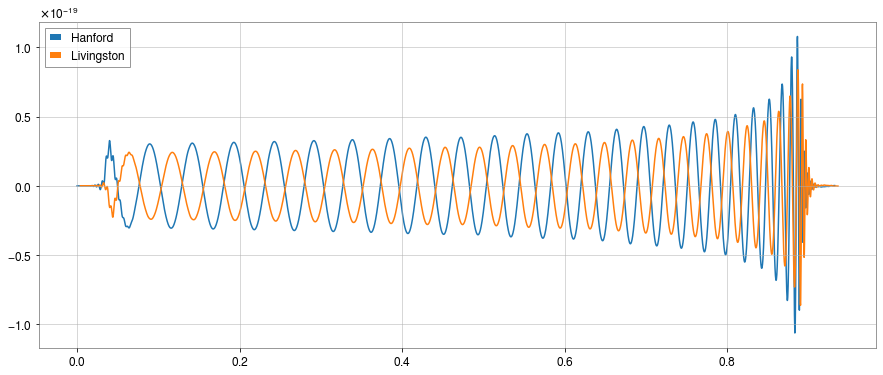

In [20]:
plt.figure(figsize = ([15, 6]))
plt.plot(timeH, strainH, label = "Hanford")
plt.plot(timeL, strainL, label = "Livingston")
plt.legend(loc = 2)
plt.show()

In [25]:
# Wrap these up as TimeSeries objects
# https://gwpy.github.io/docs/stable/timeseries/io.html

H1_data = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
L1_data = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

Zeroes = 0*np.arange(0., 2.0, dt)

H1_zeroes = TimeSeries(Zeroes,sample_rate=1/dt,epoch=timeH[0],channel='H1:LDAS_STRAIN')
L1_zeroes = TimeSeries(Zeroes,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

In [26]:
L1_padded = L1_zeroes.inject(L1_data)
H1_padded = H1_zeroes.inject(H1_data)

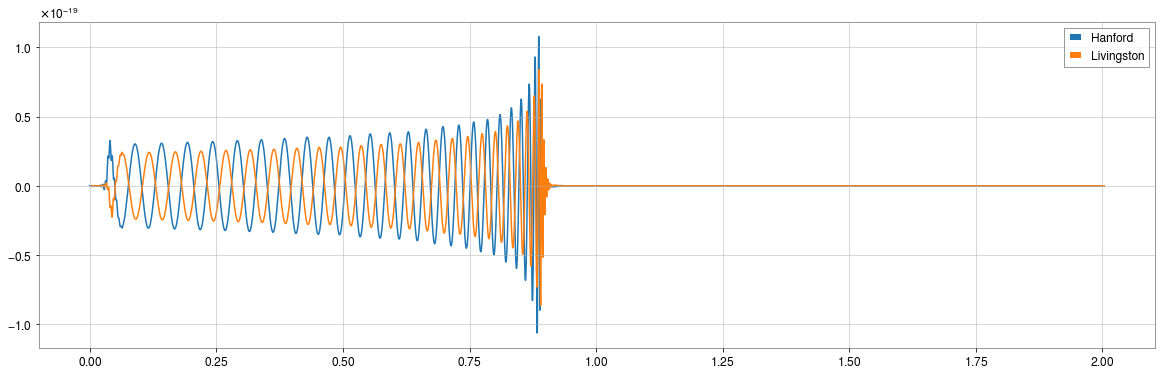

In [27]:
plt.figure(figsize = ([20, 6]))
plt.plot(H1_padded.times.value, H1_padded.value, label = 'Hanford')
plt.plot(L1_padded.times.value, L1_padded.value, label = 'Livingston')
plt.legend()
plt.show()

In [29]:
# Save
H1_padded.write("H1_GR.gwf")
L1_padded.write("L1_GR.gwf")